In [1]:
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P04_run_post_weld.T00_lib.classes import MyUtil
from P04_run_post_weld.T00_lib.utils import check_jupyter


In [2]:
SAVE_DATA = False
MAKE_ONE_HOT = True

In [3]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent / "T02_combine_features"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P04_run_post_weld/T02_combine_features"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")


# Load data
df = pd.read_excel(DATA_DIR / "S03_data_combined_single_y.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P04_run_post_weld\T03_ml_trial
Current Date and Time: 2026-01-11_20-48
(1134, 194)


,sample_no,R,W,D,position,location,fz_location,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_48","dwell_Fz__fft_coefficient__attr_""angle""__coeff_73",dwell_Fz__ar_coefficient__coeff_10__k_10,...,"weld_Fz__fft_coefficient__attr_""real""__coeff_9","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,section,stress_value
0,1,1400,60,10,0.153846,1,1.244326,-73.140582,-65.266073,-0.077099,...,58.401601,0.005640,-59.307464,-126.394608,0.000592,0.011999,1.996898,0.031761,stress_value_5052,13.0
1,2,1400,60,15,0.153846,1,1.203367,-50.581536,-23.709687,-0.187110,...,188.462577,0.008885,-67.104324,-83.441169,0.001515,0.026536,1.433742,2.139541,stress_value_5052,16.0
2,3,1400,60,20,0.153846,1,1.444542,-79.088993,-76.576054,0.025700,...,79.638692,0.007856,-73.946166,-100.226178,0.002915,0.046766,1.651073,1.957977,stress_value_5052,19.0
3,4,1400,70,10,0.153846,1,1.601667,-73.128327,-49.909967,-0.051432,...,-8.572183,-0.001150,-109.557287,-92.120362,-0.002131,0.032843,1.331185,3.615244,stress_value_5052,20.0
4,5,1400,70,15,0.153846,1,1.095031,-76.940961,-132.636340,-0.226879,...,34.610547,0.012461,142.508379,101.664911,0.005496,0.017408,1.739714,-0.003368,stress_value_5052,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,50,1600,70,15,0.846154,7,1.905742,-82.754214,-80.860107,0.047415,...,50.879103,0.000791,100.417769,70.734310,-0.000276,0.012383,2.073254,-0.284814,stress_value_center,2.0
1130,51,1600,70,20,0.846154,7,1.669120,-82.628328,-83.475567,0.120152,...,62.884040,0.006849,77.002325,105.356086,0.002244,0.000090,2.110911,-0.807980,stress_value_center,2.0
1131,52,1600,80,10,0.846154,7,1.671576,-79.571218,-87.967830,-0.044177,...,19.546750,0.005970,-114.510109,160.581335,0.002110,0.011999,1.947229,-0.492903,stress_value_center,5.0
1132,53,1600,80,15,0.846154,7,1.686495,-80.867927,-79.809782,0.024669,...,-26.434232,0.004806,49.909992,-131.625465,0.003661,0.042150,1.607697,1.674617,stress_value_center,1.0


In [4]:
colsY = ["stress_value"]
colsX = [c for c in df.columns if c not in colsY]
print("X columns:", colsX)
print("Y columns:", colsY)

X columns: ['sample_no', 'R', 'W', 'D', 'position', 'location', 'fz_location', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_48', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_73', 'dwell_Fz__ar_coefficient__coeff_10__k_10', 'dwell_Fz__ar_coefficient__coeff_6__k_10', 'dwell_Fz__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'dwell_Fz__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'dwell_Fz__quantile__q_0.2', 'dwell_Fz__quantile__q_0.3', 'dwell_Fz__quantile__q_0.1', 'dwell_Fz__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'dwell_Fz__index_mass_quantile__q_0.2', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_52', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_53', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'dwell_Fz__binned_entropy__max_bins_10', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_56', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_86', 'dwell_Fz__fft_coefficient__att

In [5]:
dfY = df[colsY]
dfX_all = df[colsX]

In [6]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(
        dfX_all,
        columns=["section", "location", "R", "W", "D"],
        drop_first=False,
        dtype=int,
    )
    dfX = dft1.drop(columns=["sample_no"])
else:
    dft1 = pd.get_dummies(dfX_all, columns=["section"], drop_first=False, dtype=int)
    dfX = dft1.drop(columns=["sample_no", "location"])
dfX

,position,fz_location,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_48","dwell_Fz__fft_coefficient__attr_""angle""__coeff_73",dwell_Fz__ar_coefficient__coeff_10__k_10,dwell_Fz__ar_coefficient__coeff_6__k_10,"dwell_Fz__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)","dwell_Fz__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)",dwell_Fz__quantile__q_0.2,dwell_Fz__quantile__q_0.3,...,location_7,R_1400,R_1500,R_1600,W_60,W_70,W_80,D_10,D_15,D_20
0,0.153846,1.244326,-73.140582,-65.266073,-0.077099,0.052888,0.430529,0.699941,2.194000,2.222030,...,0,1,0,0,1,0,0,1,0,0
1,0.153846,1.203367,-50.581536,-23.709687,-0.187110,0.061127,0.481377,0.745993,2.523190,2.552230,...,0,1,0,0,1,0,0,0,1,0
2,0.153846,1.444542,-79.088993,-76.576054,0.025700,-0.056659,0.503995,0.782887,2.486750,2.511160,...,0,1,0,0,1,0,0,0,0,1
3,0.153846,1.601667,-73.128327,-49.909967,-0.051432,-0.020606,0.546716,0.846394,2.802210,2.832860,...,0,1,0,0,0,1,0,1,0,0
4,0.153846,1.095031,-76.940961,-132.636340,-0.226879,0.099458,0.436609,0.630152,0.893424,0.922372,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0.846154,1.905742,-82.754214,-80.860107,0.047415,0.155679,0.445744,0.686188,1.498670,1.533990,...,1,0,0,1,0,1,0,0,1,0
1130,0.846154,1.669120,-82.628328,-83.475567,0.120152,-0.116347,0.401043,0.640830,1.238050,1.270270,...,1,0,0,1,0,1,0,0,0,1
1131,0.846154,1.671576,-79.571218,-87.967830,-0.044177,-0.007931,0.410541,0.633516,1.345650,1.381530,...,1,0,0,1,0,0,1,1,0,0
1132,0.846154,1.686495,-80.867927,-79.809782,0.024669,-0.114515,0.544664,0.868778,1.393080,1.496450,...,1,0,0,1,0,0,1,0,1,0


In [7]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(1134, 206)
(1134, 1)


In [8]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=0
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(793, 206)
(341, 206)
(793, 1)
(341, 1)


In [9]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

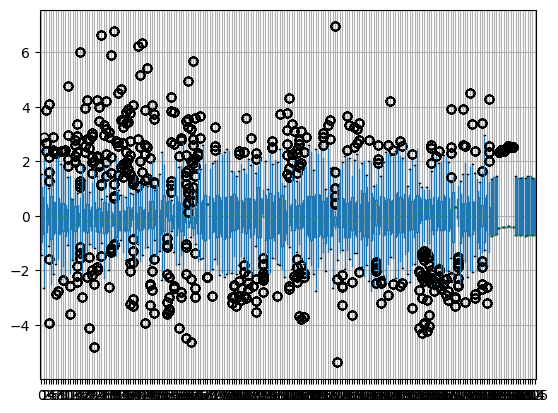

In [10]:
# _X_train.boxplot(figsize=(20,5))
pd.DataFrame(X_train).boxplot()
plt.show()

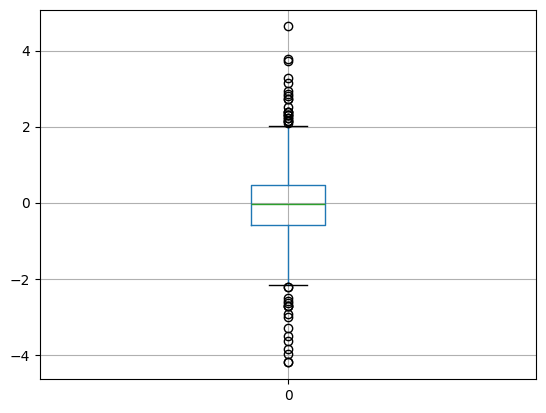

In [11]:
pd.DataFrame(Y_train).boxplot()
plt.show()

In [12]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# reg = MultiOutputRegressor(estimator=SVR(C=1))
# reg = MultiOutputRegressor(estimator=LinearRegression())
# reg = MultiOutputRegressor(
#     estimator=RandomForestRegressor(n_estimators=200, random_state=0)
# )
# reg = MultiOutputRegressor(
#     estimator=GradientBoostingRegressor(n_estimators=200, random_state=0, max_depth=5)
# )
reg = MultiOutputRegressor(
    estimator=XGBRegressor(n_estimators=200, random_state=0, max_depth=1)
)

In [13]:
reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=1,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [14]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(793, 1)
(341, 1)


In [15]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

Y : Y-1
MSE Train : 0.6815851808610495
MSE Test : 0.8638949797973456
MAPE Train : 1.56866700946759
MAPE Test : 1.7990156021167394
R2 Train : 0.31841481913895053
R2 Test : 0.1192105517009272


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,0.681585,0.863895,1.568667,1.799016,0.318415,0.119211
1,Y-All,0.681585,0.863895,1.568667,1.799016,0.318415,0.119211


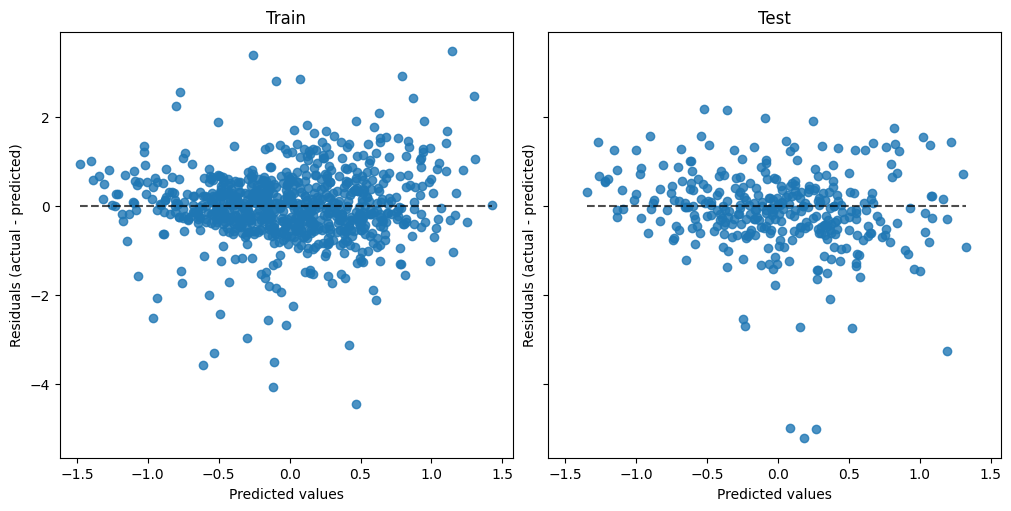

In [16]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()